# Bifurcation process synthetic data generation


### Important !!!

The execution of this notebook relies on the tree structure being the same as in [Subdirectory M2](https://github.com/bnediction/gustavo/tree/M2/M2)

In [1]:
# type hints
from typing import Iterator, Dict
RandomWalkGenerator = Iterator[Dict[str,int]]

# visualisation
import matplotlib.pyplot as plt
import plotnine as gg
import random
from networkx.drawing.nx_agraph import graphviz_layout


# data io
import numpy as np
import pandas as pd

# generation of unique identifiers for reproducibility
from IPython import get_ipython
ipython = get_ipython()
import datetime as dt

from scboolseq import scBoolSeq
from scboolseq.simulation import (
    biased_simulation_from_binary_state,
    _simulate_subset,
    simulate_gene, 
    simulate_bimodal_gene,
    simulate_unimodal_gene
)
from scboolseq.utils.customobjs import (
    Path, 
    ObjDict as odict
)
from scboolseq.utils.stream_helpers import *

# Boolean networks
import ginsim
import networkx as nx
from colomoto.minibn import *

# miscellaneous
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import jaccard, squareform, pdist
from sklearn.metrics.pairwise import pairwise_distances
import pickle
from itertools import chain, combinations, product # For powerset calculation
from functools import partial # in order to pre-load functions before passing them to
                              # a pd.DataFrame.index.map()
from scipy.spatial.distance import jaccard as jaccard_distance # To compute the similarity between critical nodes
lmap = lambda f, x: list(map(f, x))
now = lambda: str(dt.datetime.now()).split('.')[0].replace(" ", "_").replace(":", "h", 1).replace(":", "m")

# set the project root and create diferent locations
root = Path(".").resolve()
locations = odict({
    "root": root,
    "data": root.joinpath("../data/").resolve(),
    "criteriae": root.joinpath("../criteriae").resolve(),
    "synthetic_data": root.joinpath("../synthetic_data/").resolve()
})


# set seed for reproducible results
_rng_seed = 19834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)

# Visualise the paths
for name, location in locations.items():
    if not location.exists():
        raise FileNotFoundError(f"Specified location \n{location}\n does not exist !")
    #print(f"{name} -> {location}")

### Load criteriae learnt on the Nestorowa Dataset (after feature selection via STREAM)

In [2]:
criteriae = odict({
    criteria.name.replace("scBoolSeq_Nestorowa_", "").replace(".csv", ""): pd.read_csv(criteria, index_col=0)
    for criteria in locations.criteriae.glob("*csv")
})
criteriae.lkeys

['simulation_criteria']

In [3]:
criteria = criteriae.simulation_criteria
print(f"* Categories on simulation criteria:\n{criteria.Category.value_counts()}\n")
criteria.head()

* Categories on simulation criteria:
Bimodal      2922
Unimodal     1645
Discarded     201
Name: Category, dtype: int64



,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
Clec1b,0.994849,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal
Mns1,0.000000,2.066577,-1.366120,0.100242,4.743786,1.884848,10.862714,0.607455,0.392545,1.949125,7.857075,1.948831,4.743786,9.166517,0.25,1.994418,7.569707,5.575288,3.798141,4.043072,6.026639,Bimodal
Zfp758,0.000000,2.656696,-1.077530,0.410024,3.392367,0.032378,10.114596,0.802972,0.197028,0.716757,7.236947,0.952938,3.392367,8.305333,0.25,1.103814,6.430069,5.326255,1.911847,3.691636,4.635897,Bimodal
Zfp655,0.000000,2.375439,-1.429402,0.179348,4.114937,0.887514,10.453106,0.653967,0.346033,1.296866,7.308042,1.449121,4.114937,8.699362,0.25,1.419807,7.125837,5.706030,2.970440,3.740356,5.248518,Bimodal
Srxn1,0.001124,2.538884,-0.893849,0.690217,3.146476,0.006911,10.074096,0.895532,0.104468,0.303613,6.727692,0.598964,3.146476,7.578089,0.25,0.962015,5.719712,4.757697,1.682418,3.431388,4.041717,Bimodal


## Set experiment name

In [4]:
_prefix = "core_regulation2"
experiment_name = f"{_prefix}_{now()}"
experiment_name

'core_regulation2_2022-04-28_10h01m23'

## Load the model

Either declare it or use one of the preloaded models.

In [5]:
from models import CORE_REGULATION_2 as core_reg
config_bn = bn_config = core_reg.network
bn = BooleanNetwork(bn_config)
bn

G1 <- TF1
G2 <- TF1
G3 <- TF1
G4 <- TF2
G5 <- TF2
G6 <- TF2
G7 <- TF6
G8 <- TF6
G9 <- TF6
TF1 <- TF3&!TF2
TF2 <- TF3&!TF1
TF3 <- TF4
TF4 <- TF5
TF5 <- !TF6
TF6 <- !TF7
TF7 <- 1

16
# computing graph layout...


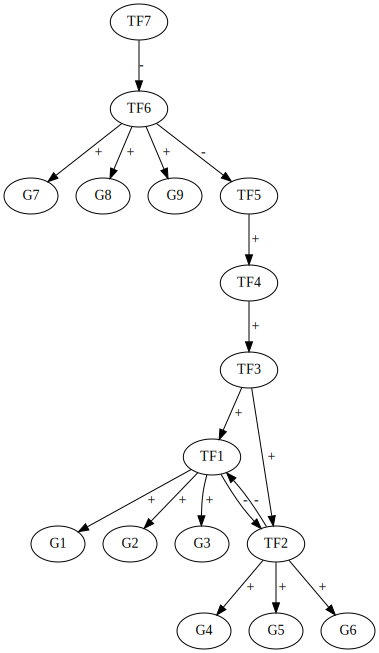

In [6]:
print(len(bn.influence_graph()))
bn.influence_graph()

In [7]:
dynamics = FullyAsynchronousDynamics(bn)

Manually declare all the states of interest

In [8]:
state_full_zero = bn.zero()
# Start copying the full-zero state
states = odict({
    state: state_full_zero.copy()
    for state in "init|branching|fixed_point_1|fixed_point_2".split("|")
})

# Declare genes which are set to one 
_states_ones = odict({
    "init": "TF6".split("|"),
    "branching": "TF3|TF4|TF5|TF7".split("|"),
    "fixed_point_1": "TF7|TF5|TF4|TF3|TF1|G1|G2|G3".split("|"),
    "fixed_point_2": "TF7|TF5|TF4|TF3|TF2|G4|G4|G6".split("|"),
})

# Iterate over 'states' dict to update the values
# performing integrity checks on each step
for _state_key in states.keys():
    if all(i in bn_config for i in _states_ones[_state_key]):
        states[_state_key].update({gene: 1 for gene in _states_ones[_state_key]})
    else:
        raise ValueError(
            "\n".join([
                f"When updating state `{_state_key}`, "
                f"at least one of {_states_ones[_state_key]} not found in the boolean network variables."
                "This is probably due to a typo, check they are all correctly spelled"
            ])
        )

## Graph-based manual construction of trajectories of interest

Compute transition graph from the initial state and show its cadinality.

Compute a subset ot the accessible transition graph from the initial state, considering the graph induced by taking the succesors of the branching point.
This may reduce the computation time of inferring the shortest trajectories from the initial state to each
one of the fixed point attractors

In [9]:
transition_graph = dynamics.partial_dynamics(states["init"])
print(f"stg has {len(transition_graph)} nodes")

stg has 176 nodes


In [10]:
condensation = nx.condensation(transition_graph)
print(f"condensation has {len(condensation)} nodes")

condensation has 176 nodes


# computing graph layout...


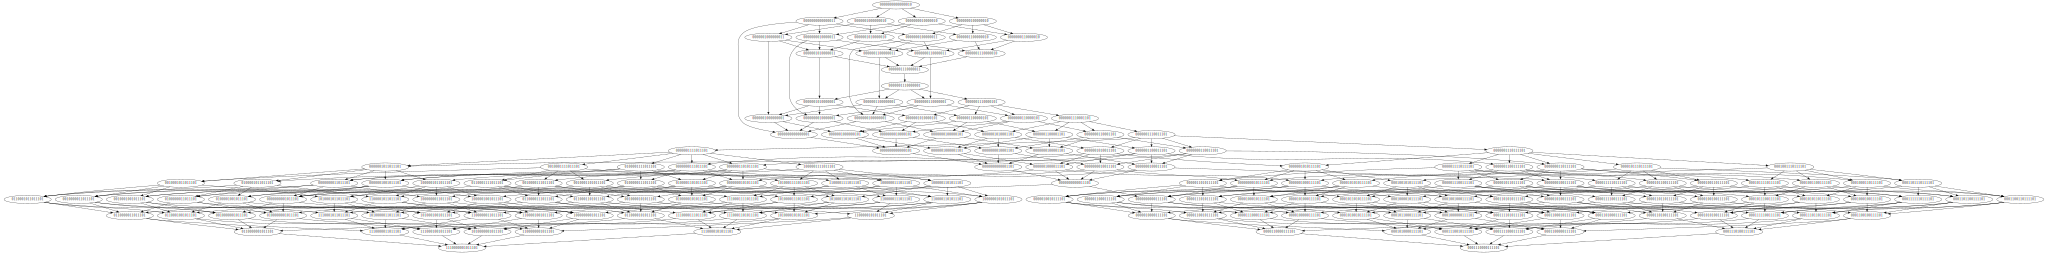

In [11]:
transition_graph

In [12]:
for _attractor in [_ for _ in states.keys() if "fixed" in _]:
    _path_len = 0
    try:
        _path_len += len(shortest_path_passing_by(
            transition_graph,
            states["init"],
            states["branching"],
            states[_attractor]
        ))
        print(f"Shortest branching path from `init` to `{_attractor}` has length {_path_len}")
    except Exception as _:
        print(f"There exist no path between `init` and {_attractor}")

Shortest branching path from `init` to `fixed_point_1` has length 10
Shortest branching path from `init` to `fixed_point_2` has length 9


## Study the attractors

In [13]:
_to_state = partial(graph_node_to_dict, dynamics)

_traj1 = map(_to_state,
    shortest_path_passing_by(
        transition_graph,
        states["init"],
        states["branching"],
        states["fixed_point_1"]
    )
)

_traj2 = map(_to_state,
    shortest_path_passing_by(
        transition_graph,
        states["init"],
        states["branching"],
        states["fixed_point_2"]
    )
)

_traj1_df = trajectory_to_data_frame(_traj1)
_traj2_df = trajectory_to_data_frame(_traj2)
_traj2_df

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
step,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
5,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
6,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1
7,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,1
8,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1


# computing graph layout...


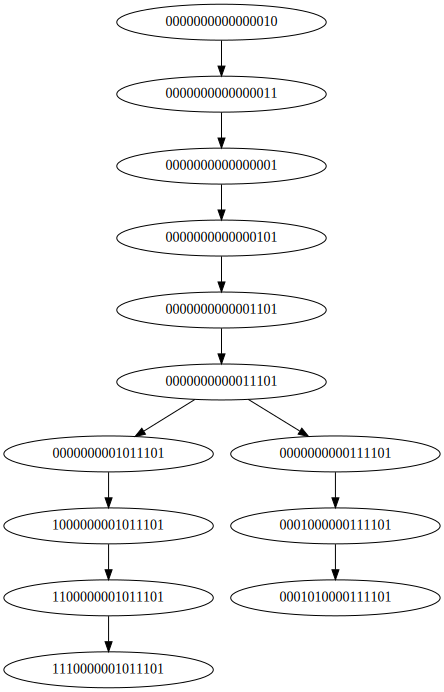

In [14]:
c1 = ["".join(map(str, d.values)) for _,d in _traj1_df.iterrows()]
c2 = ["".join(map(str, d.values)) for _,d in _traj2_df.iterrows()]
nx.DiGraph(list(zip(c1[:-1],c1[1:]))+list(zip(c2[:-1], c2[1:])))

In [15]:
len(nx.DiGraph(list(zip(c1[:-1],c1[1:]))+list(zip(c2[:-1], c2[1:]))))

13

In [16]:
boolean_df_query_generator(states["init"])

'G1 == 0 and G2 == 0 and G3 == 0 and G4 == 0 and G5 == 0 and G6 == 0 and G7 == 0 and G8 == 0 and G9 == 0 and TF1 == 0 and TF2 == 0 and TF3 == 0 and TF4 == 0 and TF5 == 0 and TF6 == 1 and TF7 == 0'

In [17]:
random_walk_df = merged_trajectories_df = merge_binary_trajectories(
    trajectories=[_traj1_df, _traj2_df],
    labels = ["fixed_point_1", "fixed_point_2"],
    branching_point_query=boolean_df_query_generator(states["branching"]),
    attractor_queries=[
        boolean_df_query_generator(states["fixed_point_1"]),
        boolean_df_query_generator(states["fixed_point_2"])
    ],
    confound_observations=True
).drop_duplicates()
merged_trajectories_df

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
common,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
common,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
common,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
common,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
common,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
split,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1
branch_fixed_point_1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1
branch_fixed_point_1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1
branch_fixed_point_1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1


In [18]:
merged_trajectories_df.reset_index().label.value_counts() / merged_trajectories_df.shape[0]

common                     0.384615
branch_fixed_point_1       0.230769
branch_fixed_point_2       0.153846
split                      0.076923
attractor_fixed_point_1    0.076923
attractor_fixed_point_2    0.076923
Name: label, dtype: float64

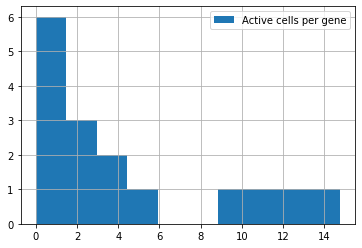

In [19]:
(merged_trajectories_df.mean() * merged_trajectories_df.shape[1] ).hist(**{"label": "Active cells per gene"})
plt.legend()

In [20]:
categories = merged_trajectories_df.reset_index().groupby("label").mean().index.to_list()
mean_exp_by_label = merged_trajectories_df.reset_index().groupby("label").mean() 
mean_exp_by_label

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
attractor_fixed_point_1,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
attractor_fixed_point_2,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
branch_fixed_point_1,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
branch_fixed_point_2,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
common,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.4,0.8
split,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [21]:
mean_bool_exp_by_label = mean_exp_by_label > 0.5
mean_bool_exp_by_label

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
label,,,,,,,,,,,,,,,,
attractor_fixed_point_1,True,True,True,False,False,False,False,False,False,True,False,True,True,True,False,True
attractor_fixed_point_2,False,False,False,True,False,True,False,False,False,False,True,True,True,True,False,True
branch_fixed_point_1,True,False,False,False,False,False,False,False,False,True,False,True,True,True,False,True
branch_fixed_point_2,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,True
common,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
split,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,True


In [22]:
jac_sim = pd.DataFrame(
    1 - pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), 
    index=mean_bool_exp_by_label.T.columns, 
    columns=mean_bool_exp_by_label.T.columns
)
jac_sim

label,attractor_fixed_point_1,attractor_fixed_point_2,branch_fixed_point_1,branch_fixed_point_2,common,split
label,,,,,,
attractor_fixed_point_1,1.0000,0.5625,0.8750,0.6875,0.5625,0.7500
attractor_fixed_point_2,0.5625,1.0000,0.6875,0.8750,0.6250,0.8125
branch_fixed_point_1,0.8750,0.6875,1.0000,0.8125,0.6875,0.8750
branch_fixed_point_2,0.6875,0.8750,0.8125,1.0000,0.7500,0.9375
common,0.5625,0.6250,0.6875,0.7500,1.0000,0.8125
split,0.7500,0.8125,0.8750,0.9375,0.8125,1.0000


In [23]:
jac_sim.mean().describe()

count    6.000000
mean     0.795139
std      0.055382
min      0.739583
25%      0.744792
50%      0.791667
75%      0.838542
max      0.864583
dtype: float64

In [24]:
dist_pdist = squareform(pairwise_distances(mean_bool_exp_by_label, metric = "hamming"), force='tovector')
dist_pdist

array([0.4375, 0.125 , 0.3125, 0.4375, 0.25  , 0.3125, 0.125 , 0.375 ,
       0.1875, 0.1875, 0.3125, 0.125 , 0.25  , 0.0625, 0.1875])

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25]],
 'dcoord': [[0.0, 0.125, 0.125, 0.0],
  [0.0, 0.0625, 0.0625, 0.0],
  [0.0, 0.15625, 0.15625, 0.0625],
  [0.125, 0.2708333333333333, 0.2708333333333333, 0.15625],
  [0.0, 0.3125, 0.3125, 0.2708333333333333]],
 'ivl': ['4', '0', '2', '1', '3', '5'],
 'leaves': [4, 0, 2, 1, 3, 5],
 'color_list': ['C1', 'C2', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C2', 'C2', 'C2']}

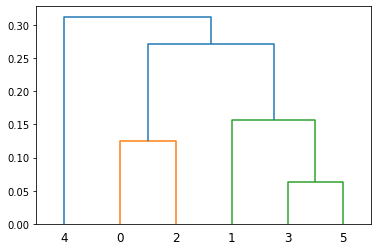

In [25]:
dendrogram(linkage(dist_pdist, method="average"))

In [26]:
# perform random sampling over bimodal genes
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(random_walk_df.columns), random_state=_rng_seed)
dummy_criteria = random_criteria.copy(deep=True).set_index(random_walk_df.columns)
dummy_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category
G1,0.000000,2.204589,-1.296402,0.030193,5.937746,8.215683,10.802706,0.384682,0.615318,2.330445,7.901582,1.511589,5.937746,8.074533,0.25,3.048493,8.326143,5.277650,7.024974,4.190001,5.790008,Bimodal
G2,0.000000,2.140588,-1.304451,0.022343,5.832109,8.004510,10.580911,0.383947,0.616053,2.428006,7.742154,1.457776,5.832109,7.568155,0.25,3.100140,8.126594,5.026454,6.759009,4.149689,5.782134,Bimodal
G3,0.004504,1.965144,-0.980230,0.015097,6.642170,8.678775,10.986034,0.330903,0.669097,2.941889,8.322288,1.659703,6.642170,7.531391,0.25,4.199070,8.845707,4.646637,7.635968,4.485248,6.325673,Bimodal
G4,0.000000,2.176400,-1.374235,0.025966,5.554317,7.572444,10.661850,0.411331,0.588669,2.249071,7.618852,1.474003,5.554317,7.885181,0.25,2.675313,7.843694,5.168381,6.493051,4.005325,5.647730,Bimodal
G5,0.000061,1.879387,-0.486789,0.006643,7.058469,8.157439,11.756951,0.257121,0.742879,3.011898,8.395932,1.567614,7.058469,6.825287,0.25,5.324472,8.902677,3.578205,7.790254,4.527685,6.256280,Bimodal
G6,0.000000,2.006684,-1.438835,0.039251,4.940110,1.981498,10.756183,0.521854,0.478146,2.281369,7.436358,1.646672,4.940110,7.662534,0.25,2.236204,7.548938,5.312735,4.847397,3.942588,5.833530,Bimodal
G7,0.008914,1.829326,0.071704,0.004831,7.328485,8.409098,11.552874,0.203062,0.796938,3.112956,8.358191,1.330458,7.328485,5.554741,0.25,6.514508,8.940043,2.425536,8.038056,4.616778,6.158220,Bimodal
G8,0.000000,2.317892,-0.841413,0.006643,6.735458,8.508093,12.133093,0.294334,0.705666,2.790051,8.317693,1.181227,6.735458,7.280929,0.25,4.148332,8.752579,4.604247,7.884896,4.731106,5.999278,Bimodal
G9,0.000000,2.031749,-1.390363,0.017512,5.737975,2.909405,12.007258,0.568352,0.431648,3.161875,8.897138,1.954851,5.737975,9.632509,0.25,2.941206,8.722994,5.781788,4.991103,5.107170,7.137512,Bimodal
TF1,0.000000,2.574075,-1.477778,0.032005,5.897388,8.547923,11.345699,0.413554,0.586446,2.054376,8.285580,1.421221,5.897388,10.089566,0.25,2.459253,8.667932,6.208679,7.271125,4.409922,5.786097,Bimodal


In [27]:
dummy_criteria.DropOutRate.describe()

count    16.000000
mean      0.020871
std       0.012251
min       0.004831
25%       0.011624
50%       0.020531
75%       0.027476
max       0.046498
Name: DropOutRate, dtype: float64

In [28]:
synthetic_single_cell_experiment, metadata = simulate_from_boolean_trajectory(
    boolean_trajectory_df=random_walk_df,
    criteria_df=dummy_criteria,
    n_samples_per_state=400,
    rng_seed=1928327465
)

In [29]:
synthetic_single_cell_experiment.head()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
common_obs0,3.743501,2.588296,1.732137,2.863299,1.717044,3.052297,2.293612,3.598360,2.069357,3.805104,2.980470,2.475668,3.448498,2.733137,8.208214,2.821934
common_obs1,1.103293,0.403474,0.000000,1.543100,3.384701,3.529317,4.681488,3.719050,0.947744,0.450221,2.756320,1.310502,3.888902,0.828259,5.784076,1.473689
common_obs2,2.909027,4.188847,2.840807,1.357670,2.994909,3.064297,0.355559,1.657030,2.170763,0.600050,1.544560,3.184032,1.727045,1.060925,8.188805,5.577210
common_obs3,0.691341,3.497351,3.861843,2.547985,3.382821,2.694003,1.692507,3.467172,3.456784,1.943013,1.823256,3.237329,2.467747,3.693185,7.388688,4.687581
common_obs4,1.791371,0.000000,2.685984,3.930876,2.408275,0.993813,2.411266,3.489611,4.087407,1.185325,2.636291,2.320471,2.815886,2.628724,7.465853,2.131968


In [30]:
synthetic_single_cell_experiment.tail()

,G1,G2,G3,G4,G5,G6,G7,G8,G9,TF1,TF2,TF3,TF4,TF5,TF6,TF7
attractor_fixed_point_2_obs5195,3.630582,2.822437,2.698496,6.465868,5.364512,4.819421,4.067930,2.639470,2.538269,2.167619,9.269162,7.409081,7.661123,7.707255,2.969473,8.966588
attractor_fixed_point_2_obs5196,2.672880,1.909382,4.243164,6.930498,2.725535,8.085661,3.985028,4.409703,3.723997,2.756253,5.732855,9.788618,8.589217,7.818430,3.203961,7.735626
attractor_fixed_point_2_obs5197,2.294588,0.000000,3.233496,8.265394,2.893412,9.331066,3.883832,2.721499,4.456654,1.280134,6.990930,10.257105,7.638590,7.276150,3.199919,6.595203
attractor_fixed_point_2_obs5198,1.035328,1.456905,3.891494,8.778540,0.000000,6.781603,1.004826,4.314687,3.138269,1.947492,8.141386,7.359120,8.232823,8.777113,1.699693,7.153562
attractor_fixed_point_2_obs5199,0.000000,4.632067,3.775992,9.090317,3.427537,6.886946,2.290062,2.258283,0.000000,2.434934,6.577514,7.452043,8.381149,7.569986,0.897175,7.504471


In [31]:
metadata.head()

,label,label_color
common_obs0,common,#65471A
common_obs1,common,#65471A
common_obs2,common,#65471A
common_obs3,common,#65471A
common_obs4,common,#65471A


In [32]:
metadata.tail()

,label,label_color
attractor_fixed_point_2_obs5195,attractor_fixed_point_2,#CE1F1C
attractor_fixed_point_2_obs5196,attractor_fixed_point_2,#CE1F1C
attractor_fixed_point_2_obs5197,attractor_fixed_point_2,#CE1F1C
attractor_fixed_point_2_obs5198,attractor_fixed_point_2,#CE1F1C
attractor_fixed_point_2_obs5199,attractor_fixed_point_2,#CE1F1C


In [33]:
EXPORT = True

if EXPORT:
    print("Exporting data...")
    metadata.to_csv(
        locations.synthetic_data.joinpath(f"metadata_{experiment_name}.tsv"), sep="\t"
    )
    synthetic_single_cell_experiment.T.to_csv(
        locations.synthetic_data.joinpath(f"branching_synthetic_{experiment_name}.tsv"), 
        sep="\t", 
        index=True
    )
    print("Done.")
    
else:
    print("Data was not exported")

Exporting data...
Done.
